[View in Colaboratory](https://colab.research.google.com/github/reetc/Dog-Breed-Classification/blob/master/Copy_of_Hello,_Colaboratory.ipynb)

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

<h1>Welcome to Colaboratory!</h1>
Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. See our [FAQ](https://research.google.com/colaboratory/faq.html) for more info.

# Setting Enviroment

This Notebook detects sideways images from limited dataset through Transfer Learning and Data Augmentation

In [0]:
!pip install -q kaggle

from google.colab import files
files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dansbecker/dogs-gone-sideways


!mkdir input
!cp dogs-gone-sideways.zip input/

rm dogs-gone-sideways.zip

!unzip input/dogs-gone-sideways.zip

!unzip images.zip

!mkdir input/dogs-gone-sideways/images


!mv train input/dogs-gone-sideways/images/
!mv val input/dogs-gone-sideways/images/

!kaggle datasets download -d keras/resnet50


!mkdir input/resnet50


!unzip resnet50.zip


!mv imagenet_class_index.json input/resnet50/
!mv resnet50_weights_tf_dim_ordering_tf_kernels.h5 input/resnet50/

!mv resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 input/resnet50/

!rm input/dogs-gone-sideways.zip

# Import tensorflow and set model path

In [0]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

num_classes = 2
resnet_weights_path = 'input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Import and compile model with changed top layer

In [0]:
# Importing A Pretrained Network and Changing the Top Layer
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
my_new_model.add(Dense(num_classes, activation='softmax'))

my_new_model.layers[0].trainable = False

my_new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Generation and Training

In [32]:
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224

"""#Specify the values for all arguments to data_generator_with_aug. Then uncomment those lines
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2)"""


data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)



# Specify which type of ImageDataGenerator above is to load in training data
train_generator = data_generator_with_aug.flow_from_directory(
        directory = 'input/dogs-gone-sideways/images/train',
        target_size=(image_size, image_size),
        batch_size=12,
        class_mode='categorical')

# Specify which type of ImageDataGenerator above is to load in validation data
validation_generator = data_generator_no_aug.flow_from_directory(
        directory = 'input/dogs-gone-sideways/images/val',
        target_size=(image_size, image_size),
        class_mode='categorical')

my_new_model.fit_generator(
        train_generator, # specify where model gets training data
        epochs = 3,
        steps_per_epoch=19,
        validation_data=validation_generator) # specify where model gets validation data


Found 220 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Epoch 1/3
19/19 [==============================] - 11s 577ms/step - loss: 0.6377 - acc: 0.6982 - val_loss: 0.2804 - val_acc: 0.8756
Epoch 2/3
19/19 [==============================] - 4s 231ms/step - loss: 0.2313 - acc: 0.9174 - val_loss: 0.2469 - val_acc: 0.8940
Epoch 3/3
19/19 [==============================] - 5s 274ms/step - loss: 0.1273 - acc: 0.9780 - val_loss: 0.1494 - val_acc: 0.9447


# Prediction images path setting

In [0]:
from os.path import join

side_image_dir = 'input/dogs-gone-sideways/images/val/sideways/'
side_img_paths = [join(side_image_dir, filename) for filename in
             ['dog.8.jpg',
              'dog.82.jpg',
              'dog.761.jpg',
              'dog.804.jpg']]

# Preprocessing

In [0]:
import numpy as np
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

image_size = 224

def read_and_prep_images(side_img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in side_img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

# Making Predictions

In [ ]:

test_data = read_and_prep_images(side_img_paths)
preds = my_new_model.predict(test_data)

# Displaying predictions

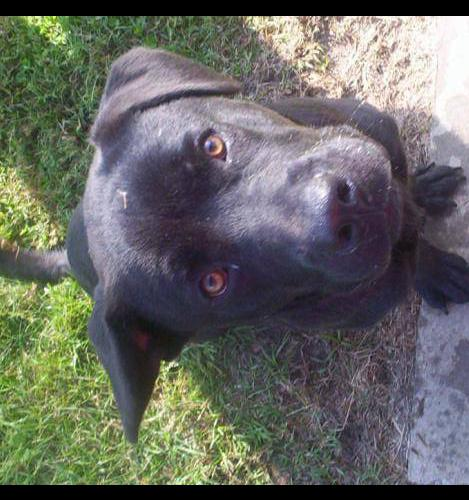

Sideways:0.8233230710029602   Upright:0.176676943898201


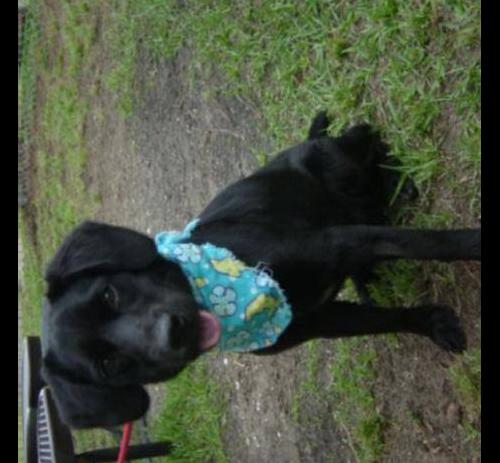

Sideways:0.9541913270950317   Upright:0.04580871760845184


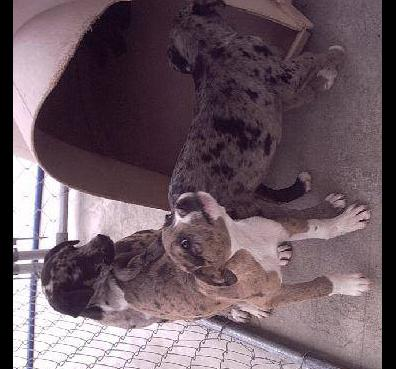

Sideways:0.9994522929191589   Upright:0.0005476779188029468


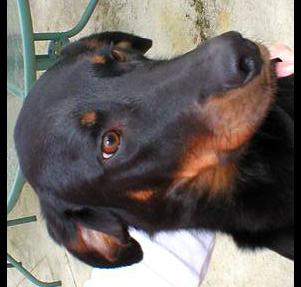

Sideways:0.7779224514961243   Upright:0.22207750380039215


In [36]:
import sys
#from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import preprocess_input, decode_predictions

#from decode_prediction import decode_predictions

from IPython.display import Image, display

# most_likely_labels = decode_predictions(preds, top=3)

for i, img_path in enumerate(side_img_paths):
    display(Image(img_path))
    print("Sideways:{}   Upright:{}".format(preds[i,0],preds[i,1]))